# Project description

Data analysis of *Fatal Police Shootings, 2015-Present, Civilians shot and killed by on-duty police officers in United States* is a capstone project of Turing College, Sprint 4 (Module 1). **Analysis aims to determine average person involved into fatal police shooting.**

General information about the dataset from Kaggle (kaggle.com/datasets/washingtonpost/police-shootings):

The Washington Post is compiling a database of every fatal shooting in the United States by a police officer in the line of duty since January 1, 2015.

In 2015, The Post began tracking more than a dozen details about each killing — including the race of the deceased, the circumstances of the shooting, whether the person was armed and whether the victim was experiencing a mental-health crisis — by culling local news reports, law enforcement websites and social media and by monitoring independent databases such as Killed by Police and Fatal Encounters.

The Post is documenting only those shootings in which a police officer, in the line of duty, shot and killed a civilian — the circumstances that most closely parallel the 2014 killing of Michael Brown in Ferguson, Missouri, which began the protest movement culminating in Black Lives Matter and an increased focus on police accountability nationwide. The Post is not tracking deaths of people in police custody, fatal shootings by off-duty officers or non-shooting deaths.

The FBI and the Centers for Disease Control and Prevention log fatal shootings by police, but officials acknowledge that their data is incomplete. In 2015, The Post documented more than two times more fatal shootings by police than had been recorded by the FBI.

The Post’s database is updated regularly as fatal shootings are reported and as facts emerge about individual cases. The Post is seeking assistance in making the database as comprehensive as possible. To provide information about fatal police shootings, send us an email at policeshootingsfeedback@washpost.com.

CREDITS
Research and Reporting: Julie Tate, Jennifer Jenkins and Steven Rich
Production and Presentation: John Muyskens, Kennedy Elliott and Ted Mellni

# Package import

Relevant package import and configuration.


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import geopandas as gpd
import plotly.express as px
import calendar
import numpy as np
import scipy.stats as stats
import statsmodels.stats.multicomp as multi

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Auto formatting of the code by nb_black package
%load_ext nb_black

<IPython.core.display.Javascript object>

# Data read
.csv file containing the data is loaded and inspected.

In [2]:
# Read the shooting data from .csv file and refer to it as "df"
df = pd.read_csv(
    "/Users/drkazimieras/turing_college/Capstone project - Shootings in US/database.csv"
)

# Read the state population data and refer to it as "state_populations"
# Ppopulation estimates for further analysis was downloaded from:
# https://www2.census.gov/programs-surveys/popest/datasets/2010-2017/national/totals/nst-est2017-alldata.csv
state_populations = pd.read_csv("population_per_state.csv")

# Read the state abbreviation and full name data and refer to it as "abbrev_to_fullname"
abbrev_to_fullname = pd.read_csv("abbrev_to_fullname.csv")

<IPython.core.display.Javascript object>

In [3]:
df.head()

id                name        date   manner_of_death       armed   age  \
0   3          Tim Elliot  2015-01-02              shot         gun  53.0   
1   4    Lewis Lee Lembke  2015-01-02              shot         gun  47.0   
2   5  John Paul Quintero  2015-01-03  shot and Tasered     unarmed  23.0   
3   8     Matthew Hoffman  2015-01-04              shot  toy weapon  32.0   
4   9   Michael Rodriguez  2015-01-04              shot    nail gun  39.0   

  gender race           city state  signs_of_mental_illness threat_level  \
0      M    A        Shelton    WA                     True       attack   
1      M    W          Aloha    OR                    False       attack   
2      M    H        Wichita    KS                    False        other   
3      M    W  San Francisco    CA                     True       attack   
4      M    H          Evans    CO                    False       attack   

          flee  body_camera  
0  Not fleeing        False  
1  Not fleeing        False  
2  Not fleeing        False  
3  Not fleeing        False  
4  Not fleeing        False

<IPython.core.display.Javascript object>

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2142 entries, 0 to 2141
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       2142 non-null   int64  
 1   name                     2123 non-null   object 
 2   date                     2142 non-null   object 
 3   manner_of_death          2142 non-null   object 
 4   armed                    2136 non-null   object 
 5   age                      2099 non-null   float64
 6   gender                   2141 non-null   object 
 7   race                     2039 non-null   object 
 8   city                     2142 non-null   object 
 9   state                    2142 non-null   object 
 10  signs_of_mental_illness  2142 non-null   bool   
 11  threat_level             2142 non-null   object 
 12  flee                     2106 non-null   object 
 13  body_camera              2142 non-null   bool   
dtypes: bool(2), float64(1), 

<IPython.core.display.Javascript object>

Dataset contains entries of 2142 victims described by 14 features. One feature is integer type, and one - float type, ten features are cathegorical, two features boolean (true/false).

In [5]:
state_populations.head()

State  population
0    AL     4850771
1    AK      738565
2    AZ     6809946
3    AR     2977944
4    CA    38982847

<IPython.core.display.Javascript object>

In [6]:
abbrev_to_fullname.head()

Abbreviation    Fullname
0           AL     Alabama
1           AK      Alaska
2           AZ     Arizona
3           AR    Arkansas
4           CA  California

<IPython.core.display.Javascript object>

Population and name data seems to be imported correctly.

# Data features clarification
Meaning of some features is unclear initially. Detailed explanation was found at GitHub repository of the project.

- id: a unique identifier for each victim

- name: the name of the victim

- date: the date of the fatal shooting in YYYY-MM-DD format

- manner_of_death:

  - shot
  - shot and Tasered

- armed: indicates that the victim was armed with some sort of implement that a police officer believed could inflict harm

  - undetermined: it is not known whether or not the victim had a weapon
  - unknown: the victim was armed, but it is not known what the object was
  - unarmed: the victim was not armed

- age: the age of the victim

- gender: the gender of the victim. The Post identifies victims by the gender they identify with if reports indicate that it differs from their biological sex.

  - M: Male
  - F: Female
  - None: unknown

- race:

  - W: White, non-Hispanic
  - B: Black, non-Hispanic
  - A: Asian
  - N: Native American
  - H: Hispanic
  - O: Other
  - None: unknown

- city: the municipality where the fatal shooting took place. Note that in some cases this field may contain a county name if a more specific municipality is unavailable or unknown.

- state: two-letter postal code abbreviation

- signs of mental illness: News reports have indicated the victim had a history of mental health issues, expressed suicidal intentions or was experiencing mental distress at the time of the shooting.

- threat_level: The threat_level column was used to flag incidents for the story by Amy Brittain in October 2015. http://www.washingtonpost.com/sf/investigative/2015/10/24/on-duty-under-fire/ As described in the story, the general criteria for the attack label was that there was the most direct and immediate threat to life. That would include incidents where officers or others were shot at, threatened with a gun, attacked with other weapons or physical force, etc. The attack category is meant to flag the highest level of threat. The other and undetermined categories represent all remaining cases. Other includes many incidents where officers or others faced significant threats.

- flee: News reports have indicated the victim was moving away from officers

  - Foot
  - Car
  - Not fleeing

The threat column and the fleeing column are not necessarily related. For example, there is an incident in which the suspect is fleeing and at the same time turns to fire at gun at the officer. Also, attacks represent a status immediately before fatal shots by police while fleeing could begin slightly earlier and involve a chase.

- body_camera: News reports have indicated an officer was wearing a body camera and it may have recorded some portion of the incident.

*Source of details: https://github.com/washingtonpost/data-police-shootings*

# Data cleaning
With additional information in mind data cleaning is performed.

In [7]:
# Rename columns for convenience
df.rename(
    columns={
        "name": "Name",
        "date": "Date",
        "manner_of_death": "Manner of death",
        "armed": "Type of arm",
        "age": "Age",
        "gender": "Gender",
        "race": "Race",
        "city": "City",
        "state": "State",
        "signs_of_mental_illness": "Signs of mental illness",
        "threat_level": "Level of threat",
        "flee": "Fleeing from officers",
        "body_camera": "Use of body camera",
    },
    inplace=True,
)

<IPython.core.display.Javascript object>

In [8]:
df.head()

id                Name        Date   Manner of death Type of arm   Age  \
0   3          Tim Elliot  2015-01-02              shot         gun  53.0   
1   4    Lewis Lee Lembke  2015-01-02              shot         gun  47.0   
2   5  John Paul Quintero  2015-01-03  shot and Tasered     unarmed  23.0   
3   8     Matthew Hoffman  2015-01-04              shot  toy weapon  32.0   
4   9   Michael Rodriguez  2015-01-04              shot    nail gun  39.0   

  Gender Race           City State  Signs of mental illness Level of threat  \
0      M    A        Shelton    WA                     True          attack   
1      M    W          Aloha    OR                    False          attack   
2      M    H        Wichita    KS                    False           other   
3      M    W  San Francisco    CA                     True          attack   
4      M    H          Evans    CO                    False          attack   

  Fleeing from officers  Use of body camera  
0           Not fleeing               False  
1           Not fleeing               False  
2           Not fleeing               False  
3           Not fleeing               False  
4           Not fleeing               False

<IPython.core.display.Javascript object>

In [9]:
# Capitalize names of the features
df["Manner of death"] = df["Manner of death"].str.capitalize()
df["Type of arm"] = df["Type of arm"].str.capitalize()
df["Level of threat"] = df["Level of threat"].str.capitalize()

<IPython.core.display.Javascript object>

In [10]:
# Remove column that has no useful information
df = df.drop(["id"], axis=1)

<IPython.core.display.Javascript object>

In [11]:
df.head()

Name        Date   Manner of death Type of arm   Age Gender  \
0          Tim Elliot  2015-01-02              Shot         Gun  53.0      M   
1    Lewis Lee Lembke  2015-01-02              Shot         Gun  47.0      M   
2  John Paul Quintero  2015-01-03  Shot and tasered     Unarmed  23.0      M   
3     Matthew Hoffman  2015-01-04              Shot  Toy weapon  32.0      M   
4   Michael Rodriguez  2015-01-04              Shot    Nail gun  39.0      M   

  Race           City State  Signs of mental illness Level of threat  \
0    A        Shelton    WA                     True          Attack   
1    W          Aloha    OR                    False          Attack   
2    H        Wichita    KS                    False           Other   
3    W  San Francisco    CA                     True          Attack   
4    H          Evans    CO                    False          Attack   

  Fleeing from officers  Use of body camera  
0           Not fleeing               False  
1           Not fleeing               False  
2           Not fleeing               False  
3           Not fleeing               False  
4           Not fleeing               False

<IPython.core.display.Javascript object>

In [12]:
# Assign full names for genders
df["Gender"] = df["Gender"].replace("M", "Male")
df["Gender"] = df["Gender"].replace("F", "Female")

<IPython.core.display.Javascript object>

In [13]:
df.head()

Name        Date   Manner of death Type of arm   Age Gender  \
0          Tim Elliot  2015-01-02              Shot         Gun  53.0   Male   
1    Lewis Lee Lembke  2015-01-02              Shot         Gun  47.0   Male   
2  John Paul Quintero  2015-01-03  Shot and tasered     Unarmed  23.0   Male   
3     Matthew Hoffman  2015-01-04              Shot  Toy weapon  32.0   Male   
4   Michael Rodriguez  2015-01-04              Shot    Nail gun  39.0   Male   

  Race           City State  Signs of mental illness Level of threat  \
0    A        Shelton    WA                     True          Attack   
1    W          Aloha    OR                    False          Attack   
2    H        Wichita    KS                    False           Other   
3    W  San Francisco    CA                     True          Attack   
4    H          Evans    CO                    False          Attack   

  Fleeing from officers  Use of body camera  
0           Not fleeing               False  
1           Not fleeing               False  
2           Not fleeing               False  
3           Not fleeing               False  
4           Not fleeing               False

<IPython.core.display.Javascript object>

In [14]:
# Assign full and detailed names for race description
replace_dict = {
    "W": "White, non-Hispanic",
    "B": "Black, non-Hispanic",
    "A": "Asian",
    "N": "Native American",
    "H": "Hispanic",
    "O": "Other",
    None: "Unknown",
}
df["Race"] = df["Race"].replace(replace_dict)

<IPython.core.display.Javascript object>

In [15]:
df.head()

Name        Date   Manner of death Type of arm   Age Gender  \
0          Tim Elliot  2015-01-02              Shot         Gun  53.0   Male   
1    Lewis Lee Lembke  2015-01-02              Shot         Gun  47.0   Male   
2  John Paul Quintero  2015-01-03  Shot and tasered     Unarmed  23.0   Male   
3     Matthew Hoffman  2015-01-04              Shot  Toy weapon  32.0   Male   
4   Michael Rodriguez  2015-01-04              Shot    Nail gun  39.0   Male   

                  Race           City State  Signs of mental illness  \
0                Asian        Shelton    WA                     True   
1  White, non-Hispanic          Aloha    OR                    False   
2             Hispanic        Wichita    KS                    False   
3  White, non-Hispanic  San Francisco    CA                     True   
4             Hispanic          Evans    CO                    False   

  Level of threat Fleeing from officers  Use of body camera  
0          Attack           Not fleeing               False  
1          Attack           Not fleeing               False  
2           Other           Not fleeing               False  
3          Attack           Not fleeing               False  
4          Attack           Not fleeing               False

<IPython.core.display.Javascript object>

In [16]:
# Check for missing values
pd.isnull(df).sum()

Name                       19
Date                        0
Manner of death             0
Type of arm                 6
Age                        43
Gender                      1
Race                        0
City                        0
State                       0
Signs of mental illness     0
Level of threat             0
Fleeing from officers      36
Use of body camera          0
dtype: int64

<IPython.core.display.Javascript object>

In [17]:
# Replace four empty cathegorical features with word "Unknown"
df[["Name", "Type of arm", "Gender", "Fleeing from officers"]] = df[
    ["Name", "Type of arm", "Gender", "Fleeing from officers"]
].fillna("Unknown")

<IPython.core.display.Javascript object>

In [18]:
pd.isnull(df).sum()

Name                        0
Date                        0
Manner of death             0
Type of arm                 0
Age                        43
Gender                      0
Race                        0
City                        0
State                       0
Signs of mental illness     0
Level of threat             0
Fleeing from officers       0
Use of body camera          0
dtype: int64

<IPython.core.display.Javascript object>

Age information of 43 victims remain missing.

In [19]:
# Fill empty values in "Age" column with average age rounded (for convenience)
avg_age = round(df["Age"].mean(), 1)
df["Age"] = df["Age"].fillna(avg_age)

print(f"Average age used to fill unknown cells was {avg_age} years.")

Average age used to fill unknown cells was 36.5 years.


<IPython.core.display.Javascript object>

In [20]:
pd.isnull(df).sum()

Name                       0
Date                       0
Manner of death            0
Type of arm                0
Age                        0
Gender                     0
Race                       0
City                       0
State                      0
Signs of mental illness    0
Level of threat            0
Fleeing from officers      0
Use of body camera         0
dtype: int64

<IPython.core.display.Javascript object>

All missing data points were cleared.

In [21]:
df.head()

Name        Date   Manner of death Type of arm   Age Gender  \
0          Tim Elliot  2015-01-02              Shot         Gun  53.0   Male   
1    Lewis Lee Lembke  2015-01-02              Shot         Gun  47.0   Male   
2  John Paul Quintero  2015-01-03  Shot and tasered     Unarmed  23.0   Male   
3     Matthew Hoffman  2015-01-04              Shot  Toy weapon  32.0   Male   
4   Michael Rodriguez  2015-01-04              Shot    Nail gun  39.0   Male   

                  Race           City State  Signs of mental illness  \
0                Asian        Shelton    WA                     True   
1  White, non-Hispanic          Aloha    OR                    False   
2             Hispanic        Wichita    KS                    False   
3  White, non-Hispanic  San Francisco    CA                     True   
4             Hispanic          Evans    CO                    False   

  Level of threat Fleeing from officers  Use of body camera  
0          Attack           Not fleeing               False  
1          Attack           Not fleeing               False  
2           Other           Not fleeing               False  
3          Attack           Not fleeing               False  
4          Attack           Not fleeing               False

<IPython.core.display.Javascript object>

Data cleaning performed, all the information seems to be ready for presentation and analysis.

# Exploratory data analysis

Analysis of the features.

## Geography

### Most likely places to encounter a fatal police shooting

In [22]:
# Count total fatal shootings per state
state_counts = df["State"].value_counts().reset_index()
state_counts.columns = ["State", "Count"]

# Heatmap total fatal shootings per state using plotly and US map
fig = px.choropleth(
    state_counts,
    locations="State",
    locationmode="USA-states",
    color="Count",
    color_continuous_scale="Blues",
    scope="usa",
    labels={"Count": "Fatal shootings statewide"},
    title="Fatal police shootings in the US",
)

fig.show()

<IPython.core.display.Javascript object>

In [23]:
# get top 10 cities with the most shootings
city_counts = df["City"].value_counts()
top_cities = city_counts.head(10)

print("Most likely to encounter fatal police shooting are in:")
print(top_cities)

Most likely to encounter fatal police shooting are in:
Los Angeles    31
Phoenix        24
Houston        24
Chicago        23
Austin         16
San Antonio    16
Las Vegas      16
Columbus       16
Miami          15
Tucson         13
Name: City, dtype: int64


<IPython.core.display.Javascript object>

California, Texas, and Florida also happens to be densely populated states, thus the high number of police shootings could be related to high number of people present. The better value to evaluate likelyhood of getting shot by police would be recalculation to police shooting cases per population.

### Map of fatal police shooting per residents of the state

In [24]:
# Count total fatal shootings per state
state_counts = df["State"].value_counts().reset_index()
state_counts.columns = ["State", "Count"]

# Merge total fatal shootings per state and population of each state
state_counts = state_counts.merge(state_populations, on="State")

# Calculate number of fatal shootings per 100 000 residents for each state
state_counts["Shootings_per_100k"] = (
    state_counts["Count"] / state_counts["population"]
) * 100000

# Heatmap total fatal shootings per state per 100 000 residents using plotly and US map
fig = px.choropleth(
    state_counts,
    locations="State",
    locationmode="USA-states",
    color="Shootings_per_100k",
    color_continuous_scale="Blues",
    scope="usa",
    labels={"Shootings_per_100k": "Fatal shootings per 100 000 residents"},
    title="Fatal police shootings in the US per 100 000 state residents",
)

fig.show()

<IPython.core.display.Javascript object>

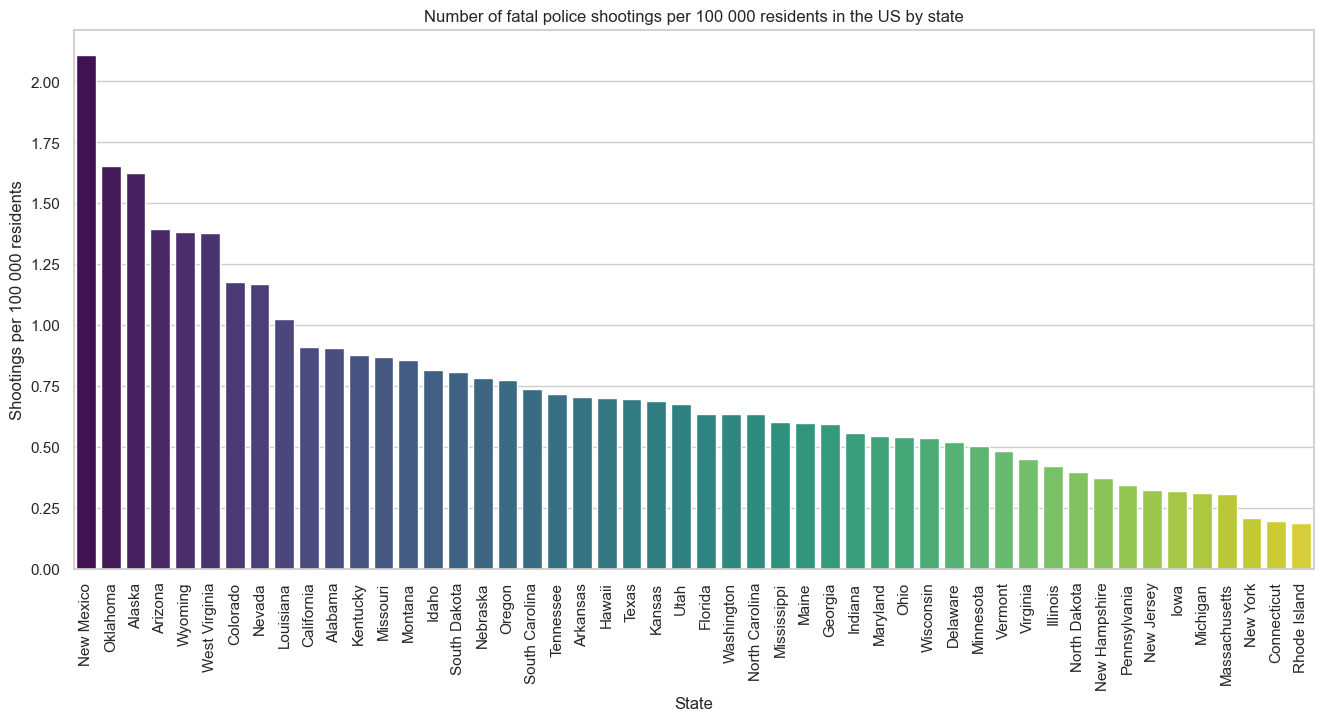

<IPython.core.display.Javascript object>

In [25]:
# Count the number of fatal shootings per state
state_counts = df["State"].value_counts().reset_index()
state_counts.columns = ["State", "Count"]

# Merge total fatal shootings per state and population of each state
state_counts = state_counts.merge(state_populations, on="State")

# Calculate number of fatal shootings per 100 000 residents for each state
state_counts["Shootings_per_100k"] = (
    state_counts["Count"] / state_counts["population"]
) * 100000

# Map the abbreviations and full names of the states and replace
abbrev_dict = abbrev_to_fullname.set_index("Abbreviation")["Fullname"].to_dict()
state_counts["State"] = state_counts["State"].map(abbrev_dict)

# Sort the fatal shootings data "Shootings_per_100k" in descending order
state_counts = state_counts.sort_values(by="Shootings_per_100k", ascending=False)

# Plot
sns.set_theme(style="whitegrid")

plt.figure(figsize=(16, 7))
bar_plot = sns.barplot(
    x="State", y="Shootings_per_100k", data=state_counts, palette="viridis"
)
plt.title("Number of fatal police shootings per 100 000 residents in the US by state")
plt.xlabel("State")
plt.ylabel("Shootings per 100 000 residents")
plt.xticks(rotation=90)
plt.show()

In [26]:
# Calculate the average fatal police shooting rate
average_shooting_rate = state_counts["Shootings_per_100k"].mean()

# Calculate the standard deviation of fatal police shooting rate
std_shooting_rate = state_counts["Shootings_per_100k"].std()

# Calculate z-score per states
state_counts["z_score"] = (
    state_counts["Shootings_per_100k"] - average_shooting_rate
) / std_shooting_rate

# Determine the critical value (around 95% confidence level)
z_critical = stats.norm.ppf(0.975)

# Find states with significant shootings
significant_states = state_counts[state_counts["z_score"].abs() > z_critical]

print(
    "States with statistically significant police shooting rates (compared to the average):"
)
print(significant_states[["State", "Shootings_per_100k", "z_score"]])

States with statistically significant police shooting rates (compared to the average):
         State  Shootings_per_100k   z_score
16  New Mexico            2.107209  3.415110
4     Oklahoma            1.653580  2.288193
37      Alaska            1.624772  2.216627


<IPython.core.display.Javascript object>

New Mexico, Oklahoma, and Alaska are among the highes shooting rates per population.  

## Type of arm

### Most common types of arms used

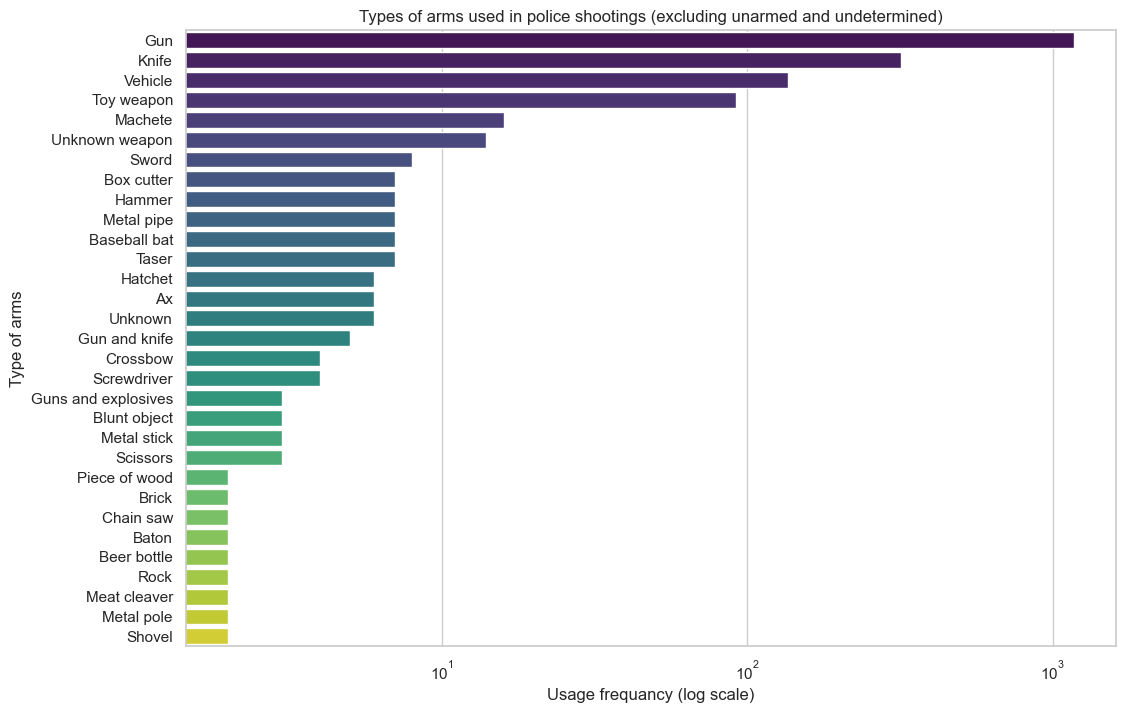

<IPython.core.display.Javascript object>

In [27]:
# Count occurrences of each type of arm used
arms_count = df["Type of arm"].value_counts()

# Filter out 'Unarmed' and 'Undetermined'
gun_count = arms_count.drop(labels=["Unarmed", "Undetermined"])
gun_count = gun_count[gun_count > 1]

# Plot horizontal bar
plt.figure(figsize=(12, 8))
sns.barplot(
    x=gun_count.values, y=gun_count.index, orient="h", dodge=False, palette="viridis"
)
sns.set_theme(style="whitegrid")
plt.xscale("log")
plt.xlabel("Usage frequancy (log scale)")
plt.ylabel("Type of arms")
plt.title("Types of arms used in police shootings (excluding unarmed and undetermined)")

plt.show()

### Rare types of arms used

In [28]:
# Count the occurrences of each type of arm
arms_count = df["Type of arm"].value_counts()

# Filter out 'Unarmed' and 'Undetermined', and keep ONLY arms used once
gun_count = arms_count.drop(labels=["Unarmed", "Undetermined"])
gun_count = gun_count[gun_count == 1]

# Sort the arms used once alphabetically
gun_count = gun_count.sort_index()

print(gun_count)

Baseball bat and fireplace poker    1
Bayonet                             1
Bean-bag gun                        1
Carjack                             1
Chain                               1
Contractor's level                  1
Cordless drill                      1
Crowbar                             1
Flagpole                            1
Flashlight                          1
Garden tool                         1
Glass shard                         1
Hand torch                          1
Hatchet and gun                     1
Lawn mower blade                    1
Machete and gun                     1
Metal hand tool                     1
Metal object                        1
Metal rake                          1
Motorcycle                          1
Nail gun                            1
Oar                                 1
Pick-axe                            1
Pipe                                1
Pitchfork                           1
Pole                                1
Pole and kni

<IPython.core.display.Javascript object>

Many types of arms vere used by suspects, the most popular being gun and knife.

## Seasonality

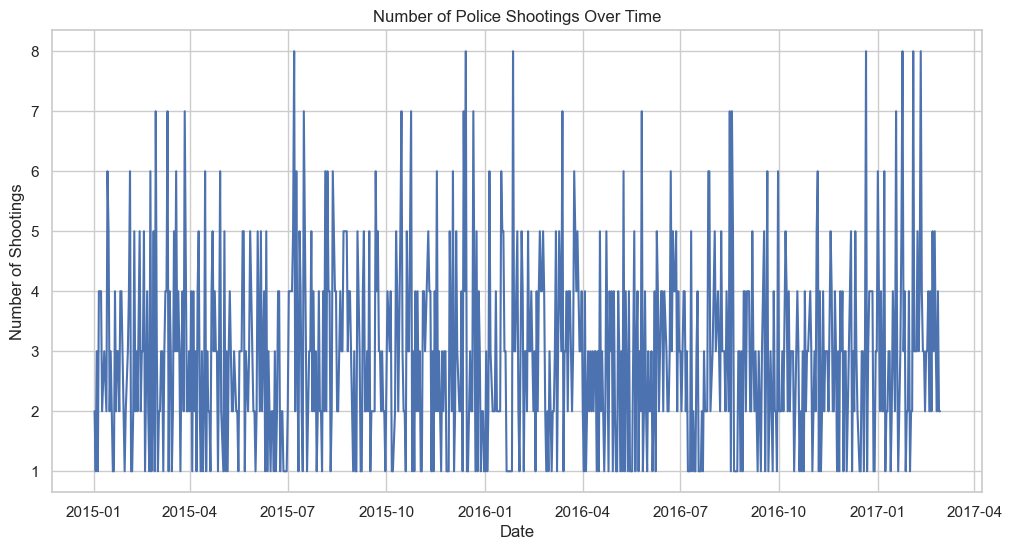

<IPython.core.display.Javascript object>

In [29]:
# Convert the date feature to a datetime object
df["Date"] = pd.to_datetime(df["Date"])

# Group by date and count the number of shootings per day
shootings_per_day = df.groupby("Date").size().reset_index(name="count")

# Plot line chart of fatal shooting
plt.figure(figsize=(12, 6))
sns.lineplot(x="Date", y="count", data=shootings_per_day)
plt.xlabel("Date")
plt.ylabel("Number of Shootings")
plt.title("Number of Police Shootings Over Time")

plt.show()

It is not easy to see any tendencies from line chart.

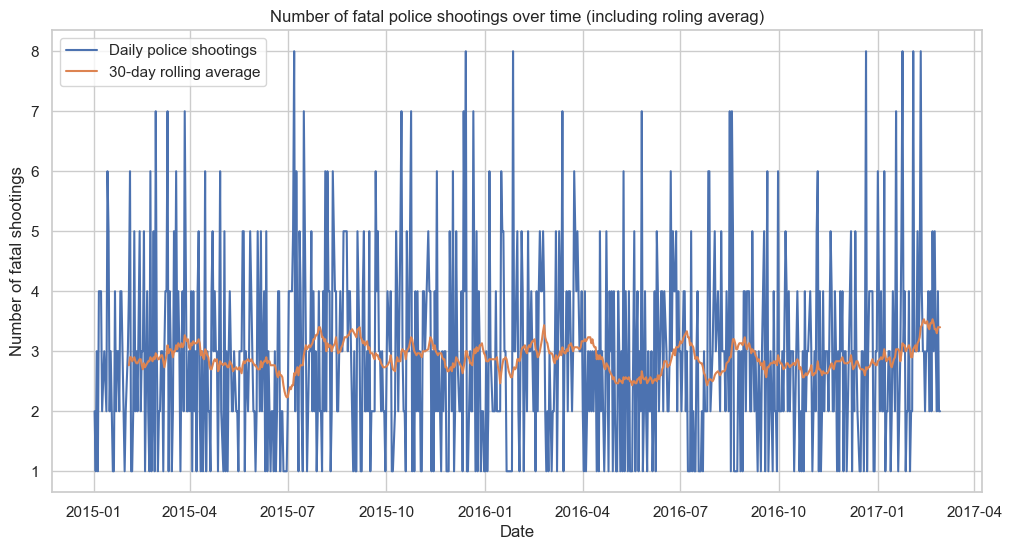

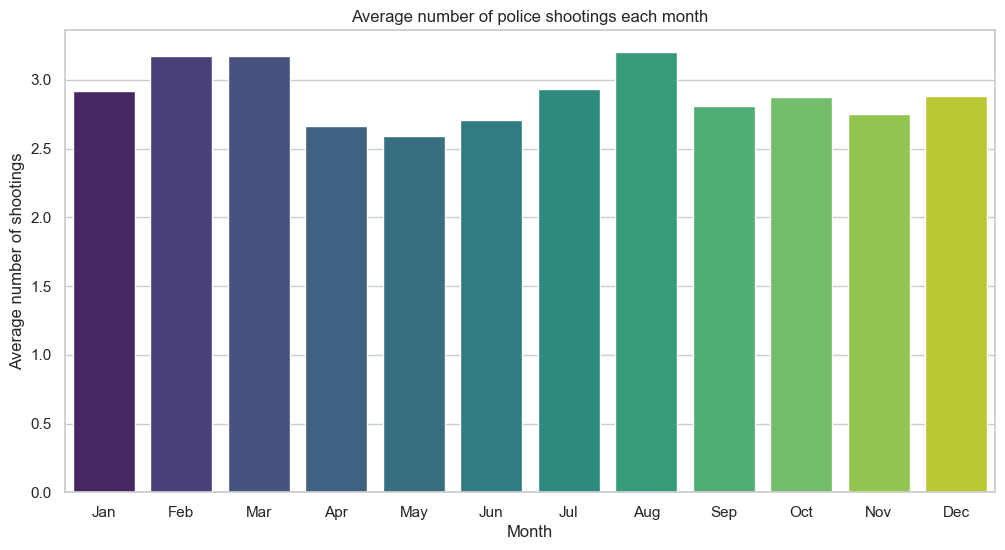

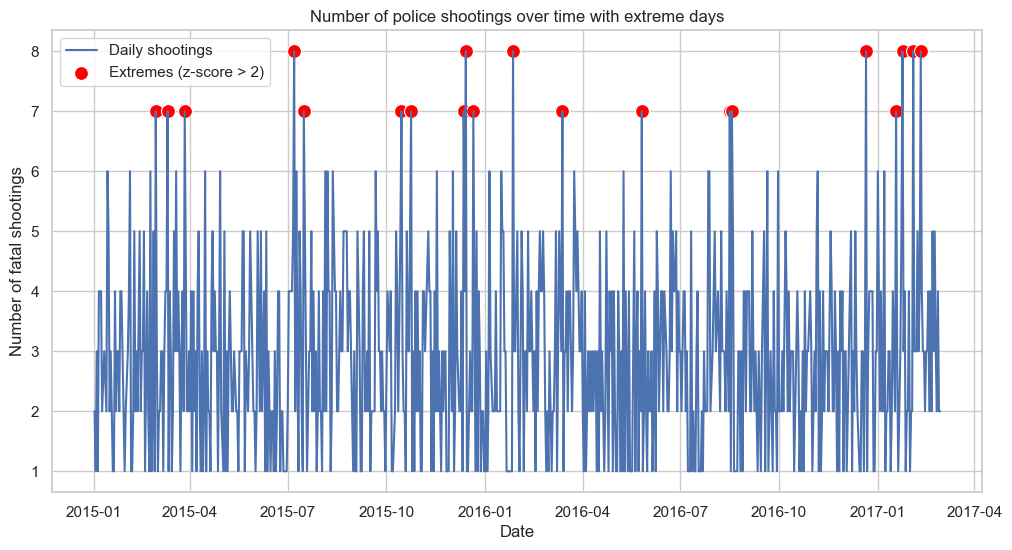

<IPython.core.display.Javascript object>

In [30]:
# Count shootinges per day
df["Date"] = pd.to_datetime(df["Date"])
shootings_per_day = df.groupby("Date").size().reset_index(name="count")

# Plot trend analysis (rolling averages)
shootings_per_day["rolling_mean"] = shootings_per_day["count"].rolling(window=30).mean()

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    x="Date", y="count", data=shootings_per_day, label="Daily police shootings"
)
sns.lineplot(
    x="Date", y="rolling_mean", data=shootings_per_day, label="30-day rolling average"
)
plt.xlabel("Date")
plt.ylabel("Number of fatal shootings")
plt.title("Number of fatal police shootings over time (including roling averag)")
plt.legend()
plt.show()

# Convert the date feature to a datetime object
shootings_per_day["Date"] = pd.to_datetime(shootings_per_day["Date"])

# Determine month number for each date
shootings_per_day["month"] = shootings_per_day["Date"].dt.month

# calculate average number of shootings per month
shootings_per_month = shootings_per_day.groupby("month")["count"].mean().reset_index()

# Convert the month numbers to abbreviated names (calendar imported already)
shootings_per_month["month_name"] = shootings_per_month["month"].apply(
    lambda x: calendar.month_abbr[x]
)

# Plot barplot (2nd)
plt.figure(figsize=(12, 6))
sns.barplot(x="month_name", y="count", data=shootings_per_month, palette="viridis")
plt.xlabel("Month")
plt.ylabel("Average number of shootings")
plt.title("Average number of police shootings each month")
plt.show()

# Anomaly detection by z-score
shootings_per_day["z_score"] = np.abs(stats.zscore(shootings_per_day["count"]))
anomalies = shootings_per_day[shootings_per_day["z_score"] > 2]

# Plot extremes (3nd plot)
plt.figure(figsize=(12, 6))
sns.lineplot(x="Date", y="count", data=shootings_per_day, label="Daily shootings")
sns.scatterplot(
    x="Date",
    y="count",
    data=anomalies,
    color="red",
    marker="o",
    s=100,
    label="Extremes (z-score > 2)",
)
plt.xlabel("Date")
plt.ylabel("Number of fatal shootings")
plt.title("Number of police shootings over time with extreme days")
plt.legend()
plt.show()

Summer and first months of the year seems to have most fatal police shootings.

In [31]:
df["Date"] = pd.to_datetime(df["Date"])

# Calculate total number of shootings
total_shootings = len(df)

# Calculate total number of days in the dataset
start_date = df["Date"].min()
end_date = df["Date"].max()
total_days = (end_date - start_date).days + 1

# Calculate overall mean number of shootings per day
mean_shootings_per_day = total_shootings / total_days

print("Average number of shootings per day:", mean_shootings_per_day)

Average number of shootings per day: 2.714828897338403


<IPython.core.display.Javascript object>

## Gender distribution

Text(0.5, 1.0, 'Gender distribution of fatal police shootings')

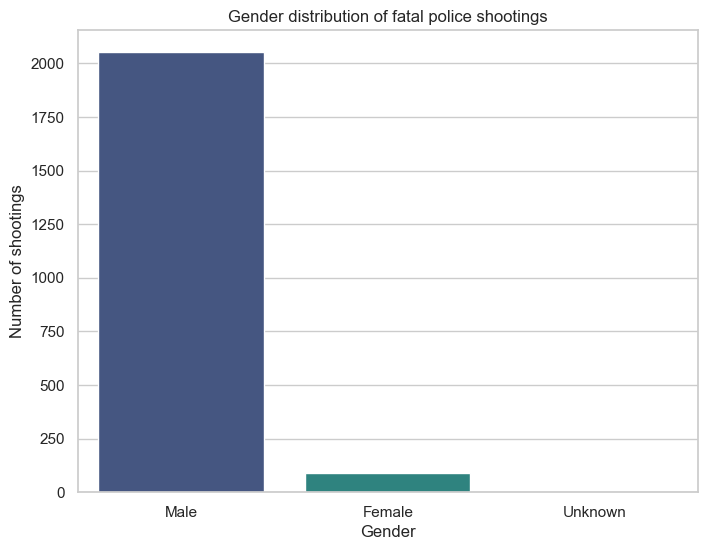

<IPython.core.display.Javascript object>

In [32]:
# Count the occurrences of each gender
gender_count = df["Gender"].value_counts().reset_index()
gender_count.columns = ["Gender", "count"]

# Plot
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))
sns.barplot(x="Gender", y="count", data=gender_count, palette="viridis")
plt.xlabel("Gender")
plt.ylabel("Number of shootings")
plt.title("Gender distribution of fatal police shootings")

## Race distribution 

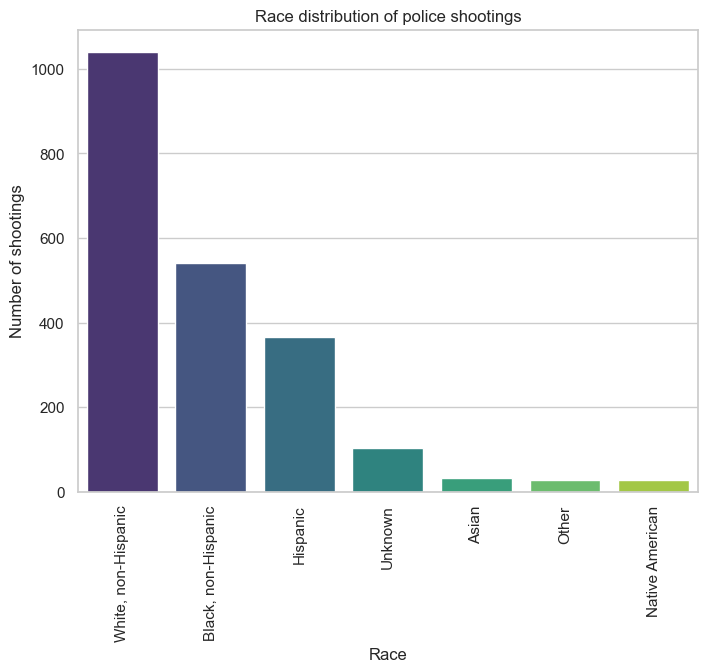

<IPython.core.display.Javascript object>

In [33]:
# Count the occurrences of each race
gender_count = df["Race"].value_counts().reset_index()
gender_count.columns = ["Race", "count"]

# Plot
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))
plt.xticks(rotation=90)
sns.barplot(x="Race", y="count", data=gender_count, palette="viridis")
plt.xlabel("Race")
plt.ylabel("Number of shootings")
plt.title("Race distribution of police shootings")
plt.show()

## Age distribution

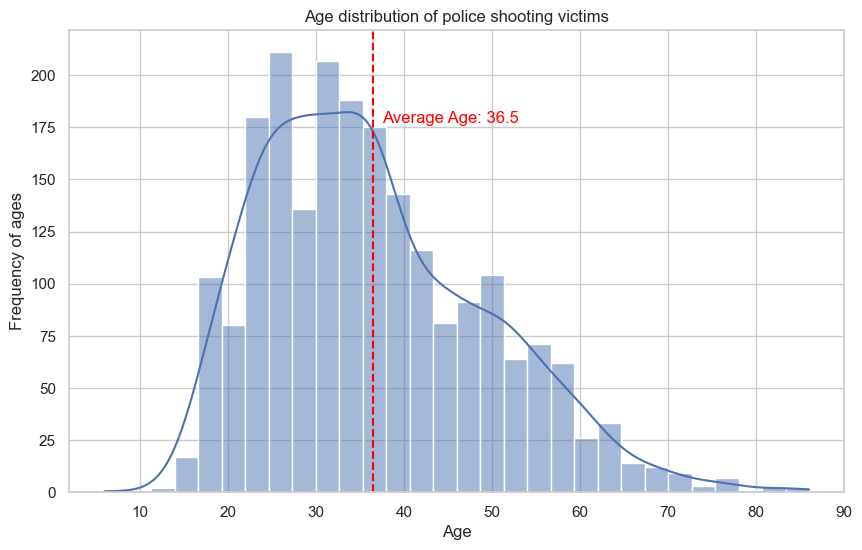

<IPython.core.display.Javascript object>

In [34]:
# Calculate average age
average_age = df["Age"].mean()

# Plot a histogram of age distribution
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="Age", bins=30, kde=True)
plt.xlabel("Age")
plt.ylabel("Frequency of ages")
plt.title("Age distribution of police shooting victims")

# Add an vertical line of average age and display the average age
plt.axvline(average_age, color="red", linestyle="--")
plt.text(
    average_age + 1,
    plt.gca().get_ylim()[1] * 0.8,
    f"Average Age: {average_age:.1f}",
    color="red",
)
plt.show()

In [35]:
# Find the youngest and oldest cases
youngest_index = df["Age"].idxmin()
oldest_index = df["Age"].idxmax()

# Display the youngest and oldest cases with all features
print("Youngest Case:")
print(df.loc[youngest_index])
print("\nOldest Case:")
print(df.loc[oldest_index])

Youngest Case:
Name                             Jeremy Mardis
Date                       2015-11-03 00:00:00
Manner of death                           Shot
Type of arm                            Unarmed
Age                                        6.0
Gender                                    Male
Race                       White, non-Hispanic
City                                Marksville
State                                       LA
Signs of mental illness                  False
Level of threat                          Other
Fleeing from officers                      Car
Use of body camera                        True
Name: 830, dtype: object

Oldest Case:
Name                         Raymond  Phillips
Date                       2015-06-11 00:00:00
Manner of death                           Shot
Type of arm                                Gun
Age                                       86.0
Gender                                    Male
Race                                   Unknown
City  

<IPython.core.display.Javascript object>

## Signs of mental illness

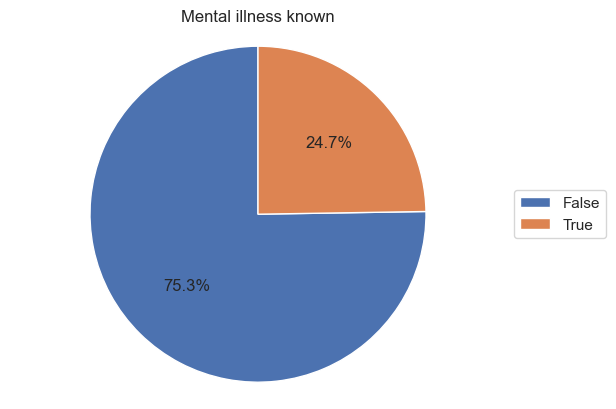

<IPython.core.display.Javascript object>

In [36]:
# Count the occurrences of mental ilness
mental = df["Signs of mental illness"].value_counts()

# Plot
sns.set_style("whitegrid")
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(mental.values, autopct="%1.1f%%", startangle=90)
ax.axis("equal")
plt.title("Mental illness known")
ax.legend(wedges, mental.index, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

## Tendency to flee

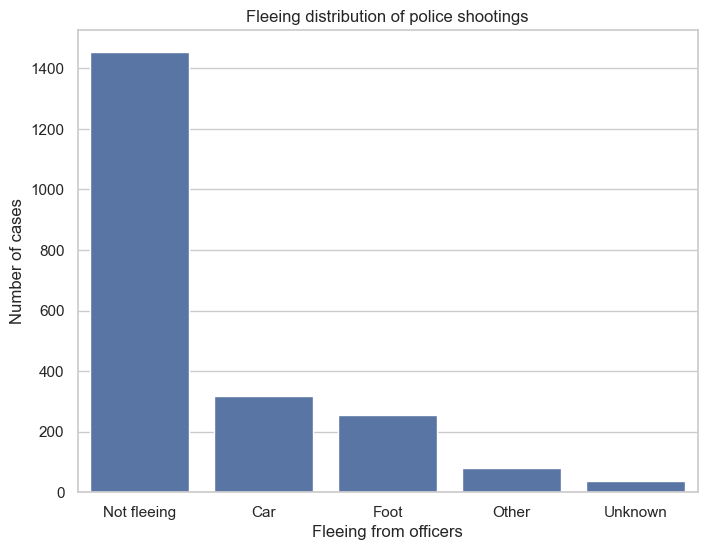

<IPython.core.display.Javascript object>

In [37]:
# Count the occurrences of flee type
flee = df["Fleeing from officers"].value_counts().reset_index()
flee.columns = ["Fleeing from officers", "count"]

# plot
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))
# plt.xticks(rotation=90)
sns.barplot(x="Fleeing from officers", y="count", data=flee, color="b")
plt.xlabel("Fleeing from officers")
plt.ylabel("Number of cases")
plt.title("Fleeing distribution of police shootings")
plt.show()

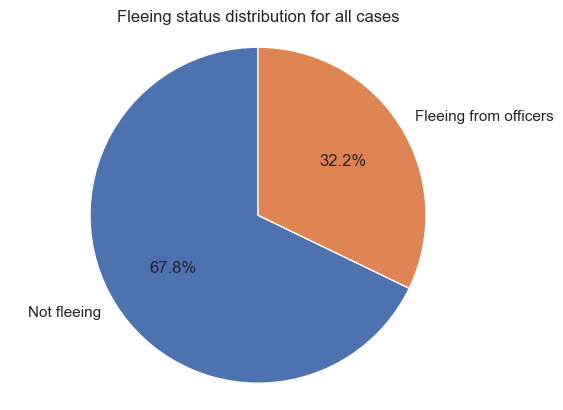

<IPython.core.display.Javascript object>

In [38]:
# Count the occurrences of each fleeing
fleeing_count = df["Fleeing from officers"].value_counts()

# Combine fleeing except for 'Not fleeing'
fleeing_count["Fleeing from officers"] = fleeing_count[
    fleeing_count.index != "Not fleeing"
].sum()

# Remove other categories, keeping only 'Not fleeing' and 'Fleeing'
fleeing_count = fleeing_count[["Not fleeing", "Fleeing from officers"]]

# Plot pie-chart
sns.set_theme()
fig, ax = plt.subplots()
ax.pie(
    fleeing_count.values, labels=fleeing_count.index, autopct="%1.1f%%", startangle=90
)
ax.axis("equal")
plt.title("Fleeing status distribution for all cases")
plt.show()

## Use of body camera

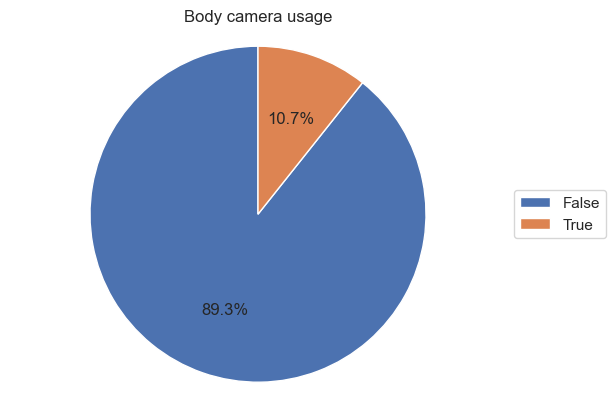

<IPython.core.display.Javascript object>

In [39]:
# Use of body camera distribution
camera = df["Use of body camera"].value_counts()

# Plot pie
sns.set_style("whitegrid")
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(camera.values, autopct="%1.1f%%", startangle=90)
ax.axis("equal")
plt.title("Body camera usage")
ax.legend(wedges, camera.index, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

## Level of threat

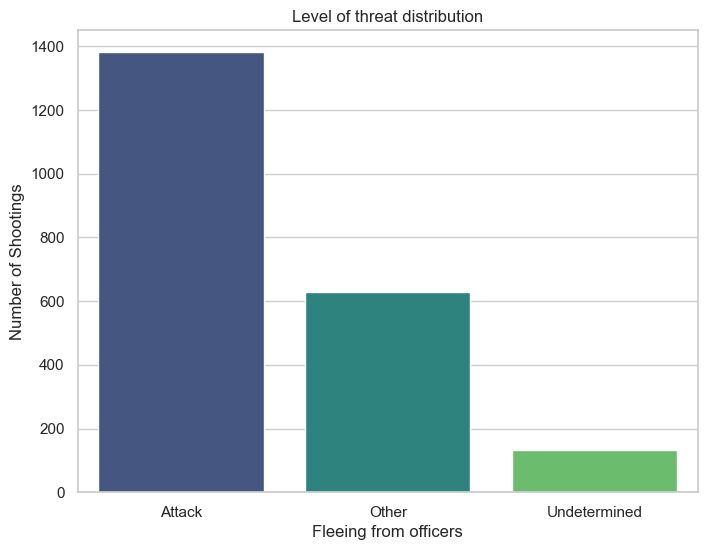

<IPython.core.display.Javascript object>

In [40]:
# Count the occurrences threats
threat = df["Level of threat"].value_counts().reset_index()
threat.columns = ["Level of threat", "count"]

# Plot
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))
# plt.xticks(rotation=90)
sns.barplot(x="Level of threat", y="count", data=threat, palette="viridis")
plt.xlabel("Fleeing from officers")
plt.ylabel("Number of Shootings")
plt.title("Level of threat distribution")
plt.show()

## Correlation between features

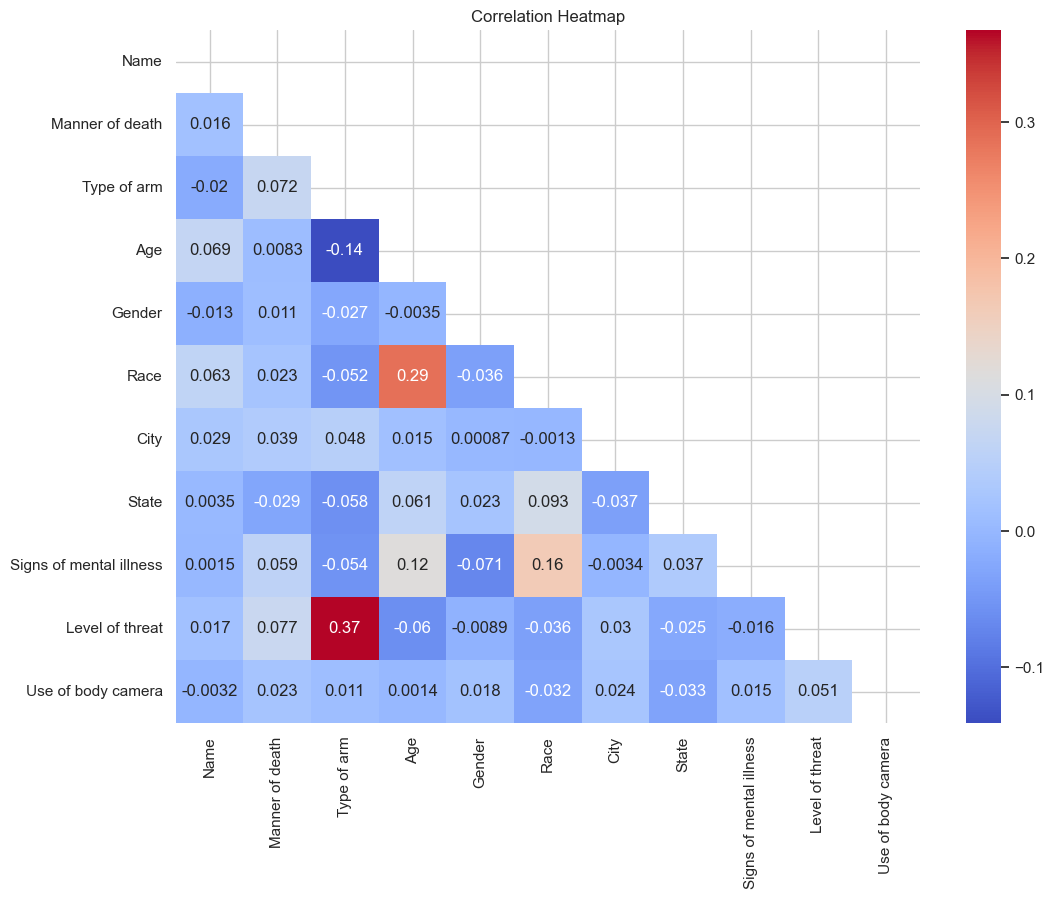

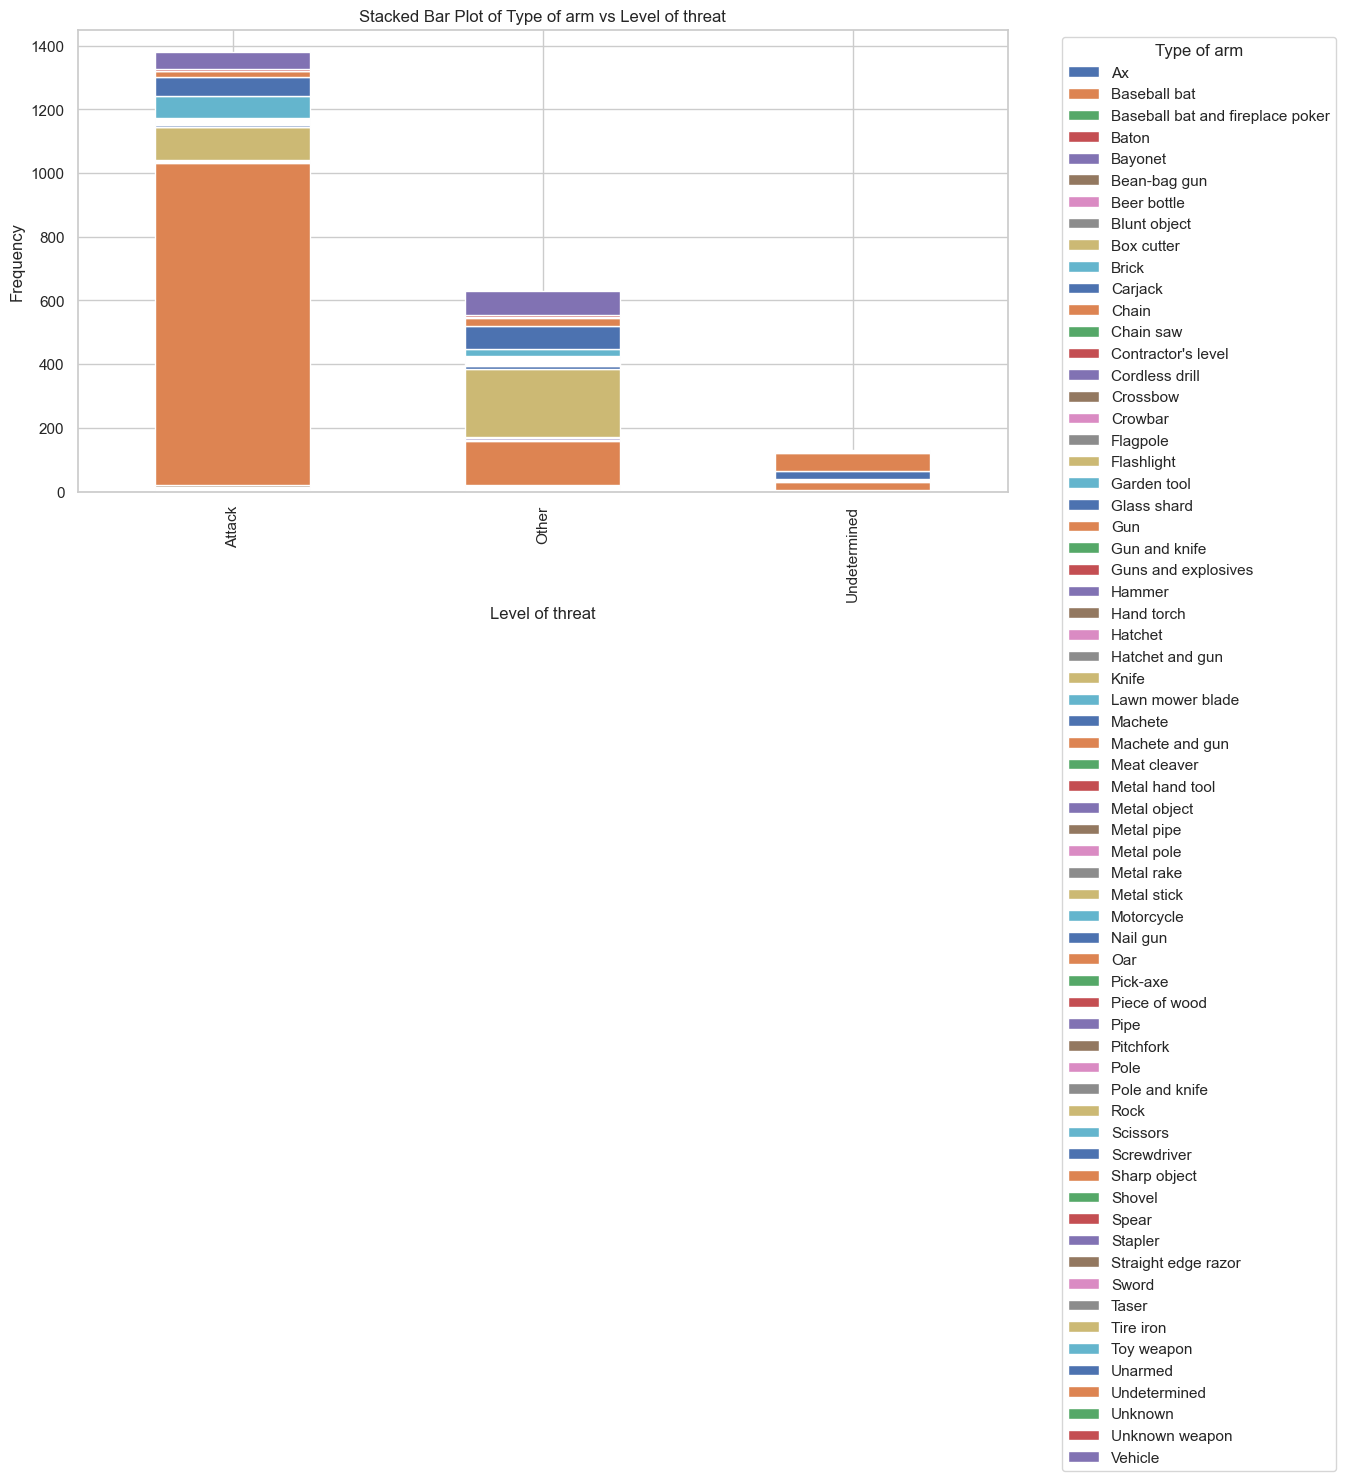

<IPython.core.display.Javascript object>

In [41]:
# Createing copy of the original df for label encoding
encoded_df = df.copy()

# Create a list of categorical features
categorical_features = [
    "Name",
    "Manner of death",
    "Type of arm",
    "Gender",
    "Race",
    "City",
    "State",
    "Level of threat",
    "Use of body camera",
]

# Perform label encoding on the copy df
encoder = LabelEncoder()
for feature in categorical_features:
    encoded_df[feature] = encoder.fit_transform(encoded_df[feature])

# Calculate correlation between features using the Pearson correlation coefficient
correlation_matrix = encoded_df.corr(method="pearson", numeric_only=True)

# Create a mask to remove the upper triangle and diagonal
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Visualize the correlation matrix using a masked heatmap
plt.figure(figsize=(12, 9))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", mask=mask)
plt.title("Correlation Heatmap")
plt.show()

# Create a cross-tabulation using the original DataFrame
original_cross_tab = pd.crosstab(df["Level of threat"], df["Type of arm"])

# Visualize by stacked bar plot with original feature names
original_cross_tab.plot(kind="bar", stacked=True, figsize=(12, 6))
plt.xticks(rotation=90)
plt.xlabel("Level of threat")
plt.ylabel("Frequency")
plt.title("Stacked Bar Plot of Type of arm vs Level of threat")
plt.legend(title="Type of arm", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

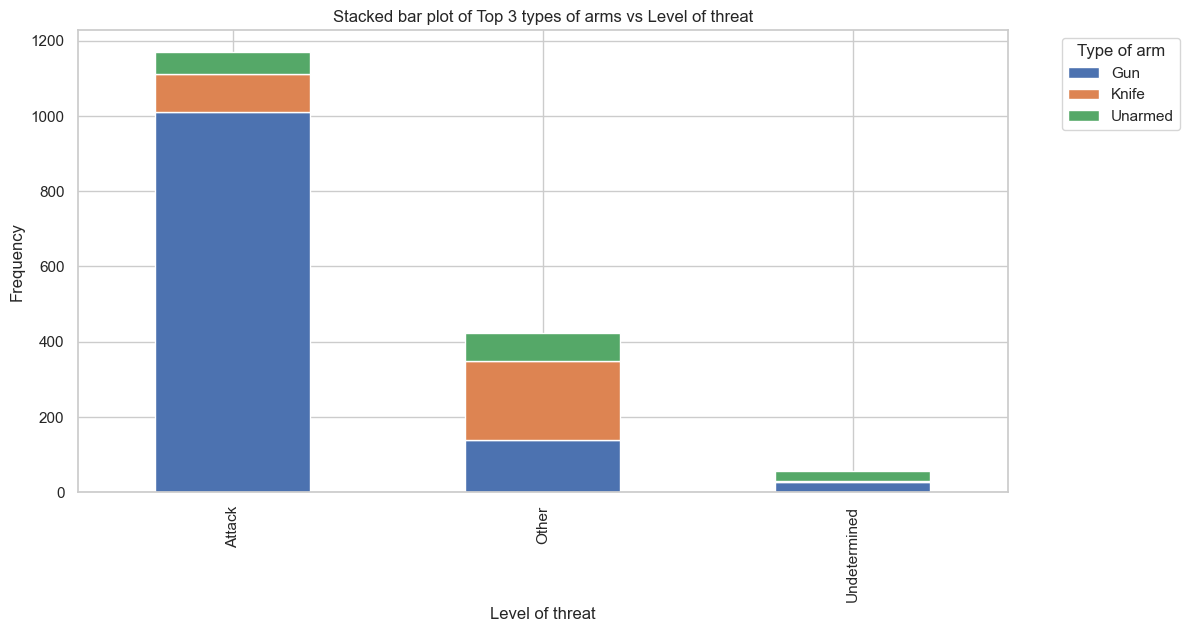

<IPython.core.display.Javascript object>

In [42]:
# Create a cross-tabulation using the original DataFrame
original_cross_tab = pd.crosstab(df['Level of threat'], df['Type of arm'])

# Find the three most frequently used types of arms
top_3_arms = original_cross_tab.sum().nlargest(3).index

# Filter the cross-tabulation to include only the top 3 types of arms
filtered_cross_tab = original_cross_tab[top_3_arms]

# Visualize the filtered cross-tabulation using a stacked bar plot with original feature names
filtered_cross_tab.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.xticks(rotation=90)
plt.xlabel('Level of threat')
plt.ylabel('Frequency')
plt.title('Stacked bar plot of Top 3 types of arms vs Level of threat')
plt.legend(title='Type of arm', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


If the suspect is attacking it is likely to do it with a gun.

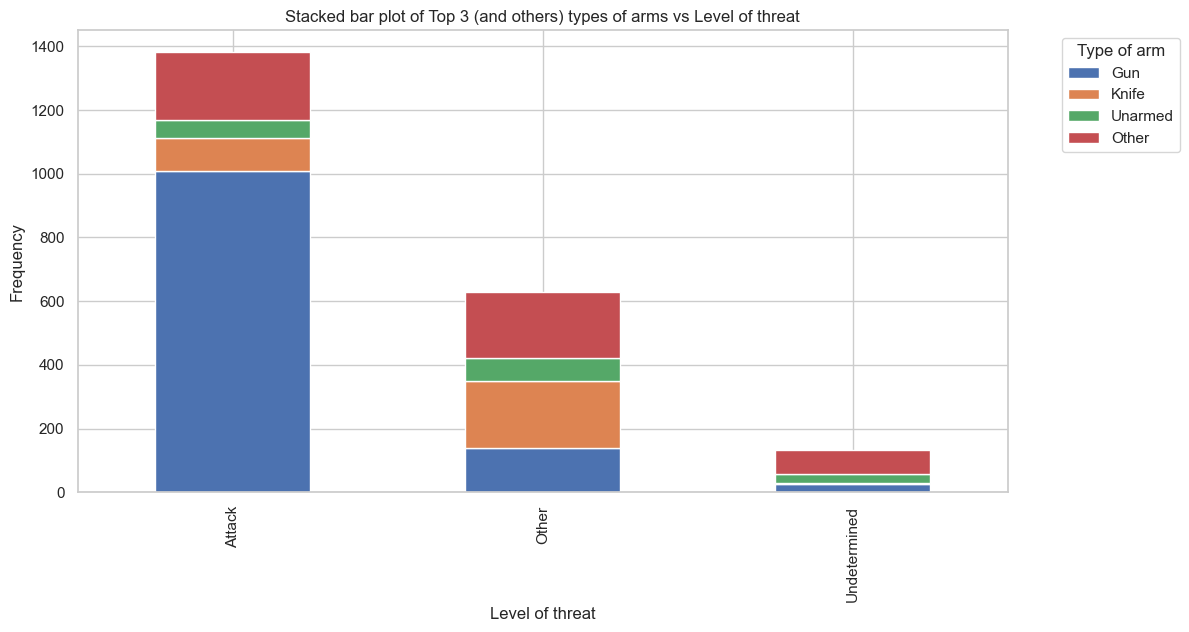

<IPython.core.display.Javascript object>

In [43]:
# Create a cross-tabulation using the original DataFrame
original_cross_tab = pd.crosstab(df['Level of threat'], df['Type of arm'])

# Find the three most frequently used types of arms
top_3_arms = original_cross_tab.sum().nlargest(3).index

# Create a new cross-tabulation with only the top 3 types of arms
filtered_cross_tab = original_cross_tab[top_3_arms]

# Calculate the sum of the counts for the less frequent types of arms and create a new DataFrame 'Other'
other_arms = original_cross_tab.drop(columns=top_3_arms)
other_df = pd.DataFrame(other_arms.sum(axis=1), columns=['Other'])

# Concatenate the filtered cross-tab and the 'Other' DataFrame
final_cross_tab = pd.concat([filtered_cross_tab, other_df], axis=1)

# Visualize the modified cross-tabulation using a stacked bar plot with original feature names
final_cross_tab.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.xticks(rotation=90)
plt.xlabel('Level of threat')
plt.ylabel('Frequency')
plt.title('Stacked bar plot of Top 3 (and others) types of arms vs Level of threat')
plt.legend(title='Type of arm', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


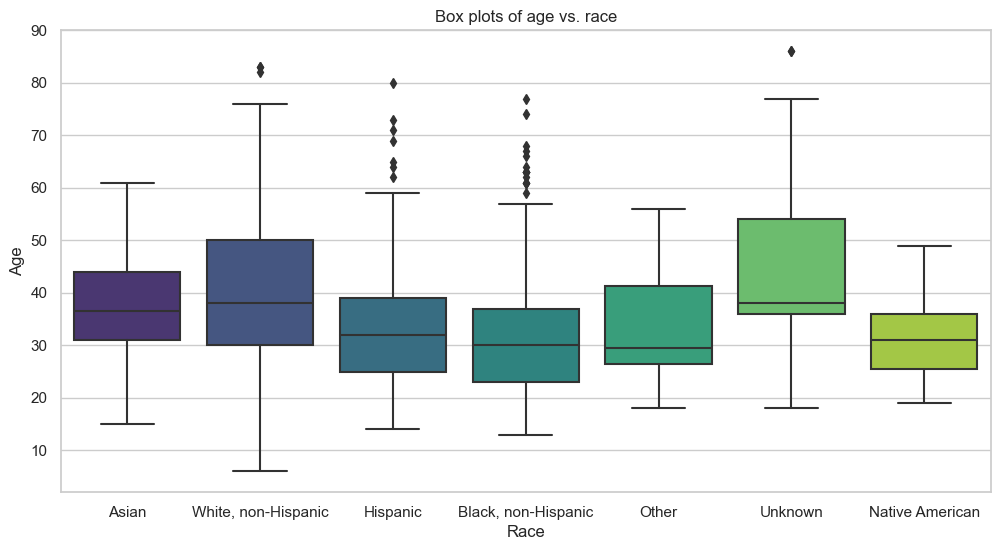

<IPython.core.display.Javascript object>

In [44]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="Race", y="Age", data=df, palette="viridis")
plt.xlabel("Race")
plt.ylabel("Age")
plt.title("Box plots of age vs. race")
plt.show()

              Multiple Comparison of Means - Tukey HSD, FWER=0.05              
       group1              group2       meandiff p-adj   lower    upper  reject
-------------------------------------------------------------------------------
              Asian Black, non-Hispanic  -5.8679 0.0986 -12.2808  0.5449  False
              Asian            Hispanic   -4.514 0.3837  -11.014   1.986  False
              Asian     Native American   -6.316 0.3969 -15.5057  2.8737  False
              Asian               Other  -4.4589 0.7845 -13.6486  4.7309  False
              Asian             Unknown   5.9357 0.1791  -1.2186   13.09  False
              Asian White, non-Hispanic   2.1978 0.9482  -4.1262  8.5219  False
Black, non-Hispanic            Hispanic    1.354 0.6478  -1.0638  3.7718  False
Black, non-Hispanic     Native American  -0.4481    1.0  -7.3797  6.4835  False
Black, non-Hispanic               Other   1.4091 0.9968  -5.5225  8.3406  False
Black, non-Hispanic             Unknown 

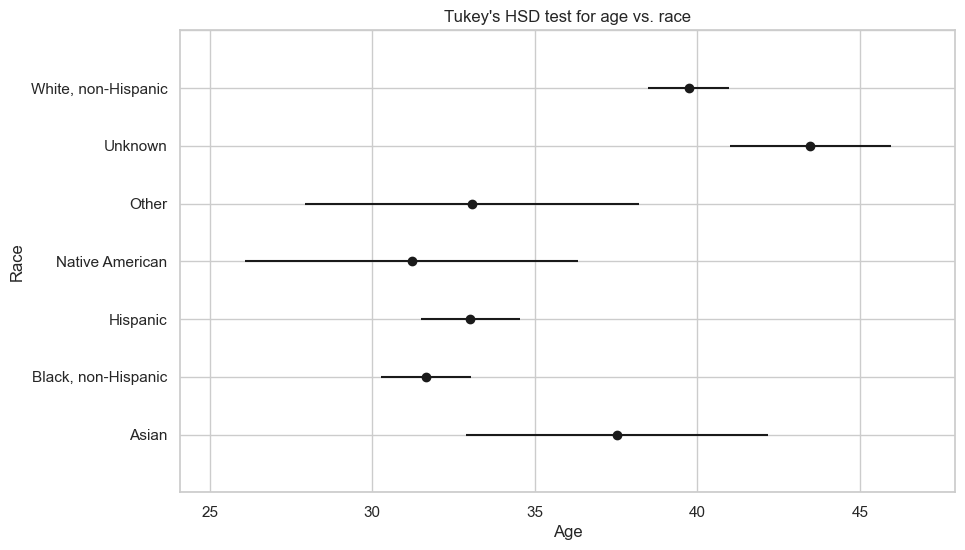

<IPython.core.display.Javascript object>

In [45]:
# Tukey's HSD test
age = df["Age"]
race = df["Race"]
tukey_hsd = multi.pairwise_tukeyhsd(endog=age, groups=race, alpha=0.05)

# Show resultant values
print(tukey_hsd)

# Plot the results
tukey_hsd.plot_simultaneous(ylabel="Race", xlabel="Age")
plt.title("Tukey's HSD test for age vs. race")
plt.show()

*The pairwise_tukeyhsd function takes three arguments: endog, the numeric variable ('Age' in this case), groups, the categorical variable ('Race'), and alpha, the significance level (0.05 by default). The function returns the test results, which can be printed and visualized. The printed output shows the pairwise comparisons between the groups, their mean differences, the confidence intervals, and whether the null hypothesis is rejected (if 'True', there's a significant difference between the group means). The plot displays the confidence intervals for the mean ages of each racial group. If the confidence intervals for two groups don't overlap, it indicates that there's a significant difference in their mean ages.*

Mean Squared Error: 151.12744016329705
R-squared: 0.019372602880871614


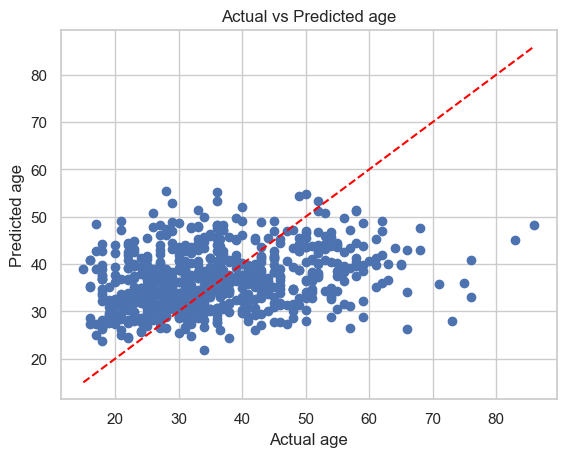

<IPython.core.display.Javascript object>

In [46]:
# Encode categorical features
categorical_features = [
    "Name",
    "Manner of death",
    "Type of arm",
    "Gender",
    "Race",
    "City",
    "State",
    "Signs of mental illness",
    "Level of threat",
    "Fleeing from officers",
    "Use of body camera",
]
le = LabelEncoder()
for feature in categorical_features:
    df[feature] = le.fit_transform(df[feature])

# Separate the target variable ('Age') from the predictor variables
X = df.drop(columns=["Age", "Date"])  # Exclude 'Date' column
y = df["Age"]

# Scale/normalize numerical variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)

# Create the regressor and fit it to the training data
rf_regressor = RandomForestRegressor(random_state=42)
rf_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_regressor.predict(X_test)

# Evaluate the regressor
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))


plt.scatter(y_test, y_pred)
plt.xlabel("Actual age")
plt.ylabel("Predicted age")
plt.title("Actual vs Predicted age")
plt.plot(
    [min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--"
)  # Plot a diagonal line
plt.show()

This scatter plot shows the actual ages on x-axis and the predicted ages on the y. Diagonal line represents a perfect prediction, where the actual age equals the predicted age. If the model's predictions are accurate, the points should be close to the red line. However, this model seems to not perform well here.

Low R-squared value means model's predictions are not very accurate. However, it was an interseting approach to implement.

# Conclusions

Average person features.

The average fatal police shooting victim is: from California armed with a gun, white, non-hispanic male, 36.5 y.o., not fleeing, but attacking the officers, without mental ilness, commiting a crime in summer.

Also, New, Mexico, Oklahoma, and Alaska should be concerned about high rate of the population involved in fatal police shootings!